In [2]:
#are we use GPU
!nvidia-smi

Wed Jul  5 12:22:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# get data
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-07-05 12:27:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.26.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.26.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   111MB/s    in 1.4s    

2023-07-05 12:27:43 (111 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
#how many images in each folder
import os
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

There are 2 directories and 0 files in '10_food_classes_10_percent'.
There are 10 directories and 0 files in '10_food_classes_10_percent/train'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 files in '10_food_classes_10_percent/train/pizza

# Prepare the data
Use the ImageDataGenerator class to load in our images in batches.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
#If you see capital in deep learning generally thats hyperparameter thats going to be used somewhere else
train_dir= "10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                                target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")#if we work with 2 class it will be BINARY

print("Test Images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                                target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")#if we work with 2 class it will be BINARY

Training Images:
Found 750 images belonging to 10 classes.
Test Images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks

In [18]:
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir=dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Creating Models using Tensorflow Hub
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [10]:
efficientnet_url ="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [12]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [13]:
from keras.layers.attention.multi_head_attention import activation
def create_model(model_url,num_classes=10):
  """
  Takes a tensorflow hub url and creates a keras sequential model with it.

  Args:
    model_url (str): A tensorflow hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer (number of target classes)

  Returns:
    An uncompiled Keras Sequential mmodel with model_url as feature extractor layer and Dense
    output layer with num_classes output neurons.
  """
  # DOwnload the pretrained model and save it as a keras layer
  feature_extractor_layer=hub.KerasLayer(model_url,trainable=False, #freeze the already learned patterns
                                         name="feature_extractor_layer",
                                         input_shape=IMAGE_SHAPE+(3,))
  #create model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation="softmax",name="outpur_layer")
  ])
  return model

# Create and Test Model

In [14]:
resnet_model= create_model(resnet_url)

In [15]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 outpur_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
#compile model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [19]:
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="resnet50v2")])


Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20230705-142935
Epoch 1/5
24/24 [==============================] - 36s 914ms/step - loss: 1.9638 - accuracy: 0.3493 - val_loss: 1.2135 - val_accuracy: 0.6280
Epoch 2/5
24/24 [==============================] - 18s 793ms/step - loss: 0.8908 - accuracy: 0.7467 - val_loss: 0.8794 - val_accuracy: 0.7192
Epoch 3/5
24/24 [==============================] - 20s 848ms/step - loss: 0.6117 - accuracy: 0.8387 - val_loss: 0.7549 - val_accuracy: 0.7624
Epoch 4/5
24/24 [==============================] - 19s 810ms/step - loss: 0.4688 - accuracy: 0.8840 - val_loss: 0.7062 - val_accuracy: 0.7732
Epoch 5/5
24/24 [==============================] - 19s 803ms/step - loss: 0.3787 - accuracy: 0.9173 - val_loss: 0.6891 - val_accuracy: 0.7744


In [20]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate lass curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))# how many epochs did we run for?

  #plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("model loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("model accuracy")
  plt.xlabel("epochs")
  plt.legend()

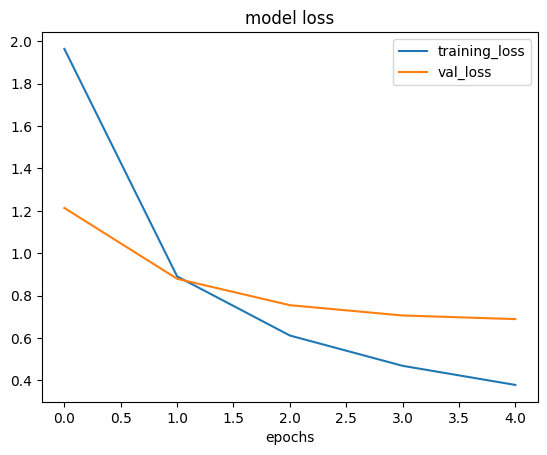

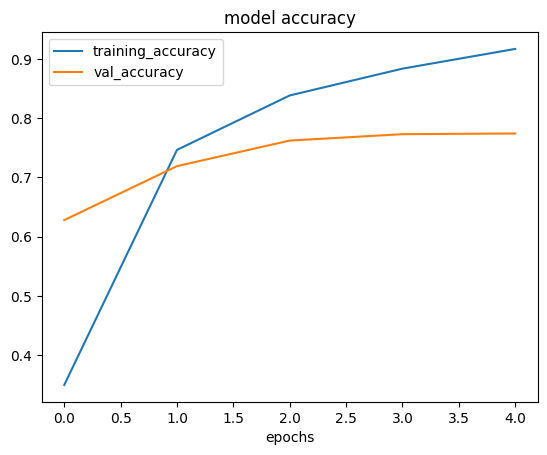

In [21]:
plot_loss_curves(resnet_history)

# EfficientNetB0 model

In [22]:
efficientnet_mmodel=create_model(model_url=efficientnet_url)
#compile model
efficientnet_mmodel.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [23]:
efficientnet_history = efficientnet_mmodel.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="efficientnetb0")])


Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230705-145104
Epoch 1/5
24/24 [==============================] - 30s 820ms/step - loss: 1.9076 - accuracy: 0.4040 - val_loss: 1.3177 - val_accuracy: 0.7380
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 1.0846 - accuracy: 0.7720 - val_loss: 0.8700 - val_accuracy: 0.8304
Epoch 3/5
24/24 [==============================] - 17s 735ms/step - loss: 0.7719 - accuracy: 0.8293 - val_loss: 0.7014 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 17s 723ms/step - loss: 0.6213 - accuracy: 0.8587 - val_loss: 0.6106 - val_accuracy: 0.8556
Epoch 5/5
24/24 [==============================] - 17s 721ms/step - loss: 0.5263 - accuracy: 0.8813 - val_loss: 0.5565 - val_accuracy: 0.8636


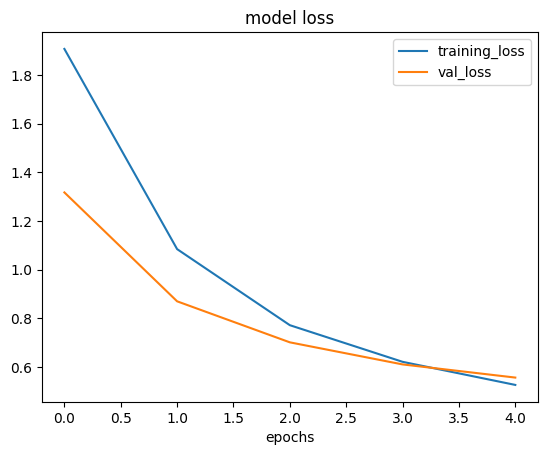

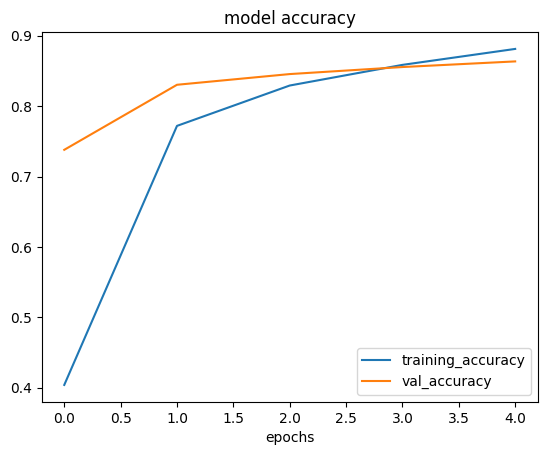

In [24]:
plot_loss_curves(efficientnet_history)

In [25]:
efficientnet_mmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 outpur_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________
